In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)
default_config = cfg.copy()

/tmp/ipykernel_3281505/2775134355.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [4]:
print(default_config.model)

{'segmentor_model': {'_target_': 'src.model.sam.CustomSamAutomaticMaskGenerator', 'points_per_batch': 64, 'stability_score_thresh': 0.97, 'box_nms_thresh': 0.7, 'min_mask_region_area': 0, 'crop_overlap_ratio': None, 'segmentor_width_size': '${model.segmentor_width_size}', 'sam': {'_target_': 'src.model.sam.load_sam', 'model_type': 'vit_h', 'checkpoint_dir': '${machine.root_dir}/pretrained/segment-anything/'}}, 'descriptor_model': {'_target_': 'src.model.dinov2.CustomDINOv2', 'model_name': 'dinov2_vitl14', 'model': {'_target_': 'torch.hub.load', 'repo_or_dir': 'facebookresearch/dinov2', 'model': '${model.descriptor_model.model_name}'}, 'token_name': 'x_norm_clstoken', 'descriptor_width_size': '${model.descriptor_width_size}', 'image_size': 224, 'chunk_size': 16}, '_target_': 'src.model.detector.CNOS', 'log_interval': 5, 'log_dir': '${save_dir}', 'segmentor_width_size': 640, 'descriptor_width_size': 640, 'post_processing_config': {'mask_post_processing': {'min_box_size': 0.05, 'min_mask_

In [5]:
# {'segmentor_model': {'_target_': 'src.model.sam.CustomSamAutomaticMaskGenerator', 'points_per_batch': 64, 'stability_score_thresh': 0.97, 'box_nms_thresh': 0.7, 'min_mask_region_area': 0, 'crop_overlap_ratio': None, 'segmentor_width_size': '${model.segmentor_width_size}', 'sam': {'_target_': 'src.model.sam.load_sam', 'model_type': 'vit_h', 'checkpoint_dir': '${machine.root_dir}/pretrained/segment-anything/'}}, 'descriptor_model': {'_target_': 'src.model.dinov2.CustomDINOv2', 'model_name': 'dinov2_vitl14', 'model': {'_target_': 'torch.hub.load', 'repo_or_dir': 'facebookresearch/dinov2', 'model': '${model.descriptor_model.model_name}'}, 'token_name': 'x_norm_clstoken', 'descriptor_width_size': '${model.descriptor_width_size}', 'image_size': 224, 'chunk_size': 16}, '_target_': 'src.model.detector.CNOS', 'log_interval': 5, 'log_dir': '${save_dir}', 'segmentor_width_size': 640, 'descriptor_width_size': 640, 'post_processing_config': {'mask_post_processing': {'min_box_size': 0.05, 'min_mask_size': 0.0003}, 'nms_thresh': 0.25}, 'matching_config': {'metric': {'_target_': 'src.model.loss.PairwiseSimilarity', 'metric': 'cosine', 'chunk_size': 16}, 'aggregation_function': 'avg_5', 'confidence_thresh': 0.01}, 'onboarding_config': {'rendering_type': 'pbr', 'reset_descriptors': False, 'level_templates': 0}}


In [6]:
cfg.dataset_name 

# 1. Load Query Dataset
Load images from test folder

In [13]:
from torch.utils.data import DataLoader
from hydra.utils import instantiate

dataset_name = "icbin"
query_dataloader_config = default_config.data.query_dataloader
default_config.dataset_name = dataset_name

if default_config.dataset_name in ["hb", "tless"]:
    query_dataloader_config.split = "test_primesense"
else:
    query_dataloader_config.split = "test"
query_dataloader_config.root_dir = "./datasets/bop23_challenge/datasets/" + f"{default_config.dataset_name}" # ./datasets/bop23_challenge/datasets/tless
query_dataset = instantiate(query_dataloader_config) # src.dataloader.bop.BaseBOPTest for tless
query_dataloader = DataLoader(
    query_dataset,
    batch_size=1,  # only support a single image for now
    num_workers=default_config.machine.num_workers,
    shuffle=False,
)

Loading metaData: 100%|██████████| 3/3 [00:00<00:00, 1161.00it/s]


In [14]:
query_dataset[0].keys()

dict_keys(['image', 'scene_id', 'frame_id'])

# 2. Load model

In [16]:
from hydra.utils import instantiate

default_model_config = cfg.model
ref_default_model_config = default_model_config.copy()
ref_default_model_config.dataset_name = dataset_name
cnos_model = instantiate(ref_default_model_config)

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


# 3. Load Reference Dataset

In [58]:
import glob
import os

obj_id = 1
obj_id_2 = 2
real_data_type = "test" # test

# Load original templates when before putting through dinov2 we also apply transfomation.
real_template_path_1 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id:06d}_original" 
real_template_path_2 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
real_template_files_1 = sorted(glob.glob(os.path.join(real_template_path_1, "*.png")), key=os.path.getmtime)
real_template_files_2 = sorted(glob.glob(os.path.join(real_template_path_2, "*.png")), key=os.path.getmtime)
real_template_files = real_template_files_1 + real_template_files_2
real_num_templates = len(real_template_files)
real_num_templates

324

In [59]:
import glob
import os

obj_id_2 = 2
syn_data_type = "train_pbr" # test

# Load original templates when before putting through dinov2 we also apply transformation.
syn_template_path_1 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_num_templates

324

In [60]:
import glob
import os

obj_id_2 = 2

# Load original templates when before putting through dinov2 we also apply transformation.
pyrender_template_path_1 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id:06d}" 
pyrender_template_path_2 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id_2:06d}" 
pyrender_template_files_1 = sorted(glob.glob(os.path.join(pyrender_template_path_1, "*.png")), key=os.path.getmtime)
pyrender_template_files_2 = sorted(glob.glob(os.path.join(pyrender_template_path_2, "*.png")), key=os.path.getmtime)
pyrender_template_files = pyrender_template_files_1 + pyrender_template_files_2
pyrender_num_templates = len(pyrender_template_files)
pyrender_num_templates

1284

In [63]:
import os
import glob

ref_dataloader_config = default_config.data.reference_dataloader

ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{default_config.dataset_name }"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "test" # train_pbr

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{default_config.dataset_name}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{default_config.dataset_name}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"
ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
ref_dataset.load_processed_metaData(reset_metaData=True)

Loading metaData: 100%|██████████| 3/3 [00:00<00:00, 98.47it/s]
Finding nearest rendering close to template poses: 100%|██████████| 2/2 [00:00<00:00, 206.33it/s]


In [64]:
ref_dataset

In [65]:
ref_dataset[0]["templates"].shape # num_templates = num of templates

torch.Size([162, 3, 224, 224])

In [66]:
len(ref_dataset) # = number of objects of this dataset

2

In [67]:
ref_dataset[0]["templates"].shape

torch.Size([162, 3, 224, 224])

# 4. Test

In [68]:
segmentation_name = default_config.model.segmentor_model._target_.split(".")[-1] # CNOS
agg_function = default_config.model.matching_config.aggregation_function #avg_5 means average of top 5
rendering_type = default_config.model.onboarding_config.rendering_type # pbr
level_template = default_config.model.onboarding_config.level_templates # 0: which is coarse
cnos_model.name_prediction_file = f"{segmentation_name}_template_{rendering_type}{level_template}_agg{agg_function}_{cfg.dataset_name}" # just the file name
cnos_model.dataset_name = dataset_name
cnos_model.log_dir = "output_cnos_analysis_5"
cnos_model.ref_dataset = ref_dataset
cnos_model = cnos_model.to("cuda")

In [69]:
# cnos_model.move_to_device()
cnos_model.custom_test_step(query_dataset[0], idx=0) # unsqueeze(0) to make input as bactchize, W

Computing descriptors ...: 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]


0

In [70]:
# save as json file
cnos_model.custom_test_epoch_end()

Loading results ...: 100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]


In [71]:
import json
file_path = "output_cnos_analysis_5/CustomSamAutomaticMaskGenerator_template_pbr0_aggavg_5_None.json"
file = json.load(open(file_path, 'r'))

In [72]:
print(len(file))
for idx in range(len(file)):
    print(file[idx])

37
{'scene_id': 1, 'image_id': 51, 'category_id': 1, 'bbox': [174, 232, 79, 95], 'score': 0.8665022253990173, 'time': 2.3709797859191895, 'segmentation': {'counts': [83828, 5, 472, 10, 468, 14, 464, 17, 460, 21, 455, 26, 452, 29, 449, 32, 445, 36, 442, 38, 441, 40, 439, 42, 437, 43, 436, 45, 432, 48, 430, 50, 422, 2, 2, 55, 415, 65, 401, 79, 399, 82, 397, 83, 394, 86, 392, 88, 390, 90, 389, 91, 389, 91, 388, 92, 388, 92, 387, 93, 386, 94, 386, 94, 385, 94, 386, 94, 386, 93, 386, 93, 387, 92, 388, 91, 389, 91, 389, 90, 390, 89, 391, 87, 393, 86, 394, 85, 395, 84, 396, 82, 398, 81, 400, 79, 401, 77, 403, 76, 404, 75, 406, 72, 408, 71, 410, 69, 411, 67, 413, 66, 414, 65, 416, 62, 418, 60, 421, 58, 422, 57, 424, 54, 427, 52, 428, 50, 431, 48, 432, 47, 434, 45, 435, 44, 437, 41, 440, 39, 442, 37, 444, 35, 445, 35, 446, 33, 448, 31, 450, 30, 451, 27, 455, 23, 458, 21, 462, 16, 470, 8, 185491], 'size': [480, 640]}}
{'scene_id': 1, 'image_id': 51, 'category_id': 1, 'bbox': [265, 305, 83, 85], 

see the results la we will have for each image 
zB for scene_id = 1 and frame_id/image_id = 51 
we bascially get 36 segmnetation with category and bbox for that, also similarity scores for that and that if they are < 0.5 then they will be visualize

# 5. Visualize The Results

In [73]:
import hydra
import numpy as np
import json
import cv2
from pycocotools import mask as mutils
from pycocotools import _mask as coco_mask
from skimage.feature import canny
from skimage.morphology import binary_dilation
import matplotlib.pyplot as plt
import logging
import distinctipy
import torch
from torchvision.ops import masks_to_boxes
from src.utils.inout import load_json
import os
from segment_anything.utils.amg import rle_to_mask
from omegaconf import DictConfig
from PIL import Image
from tqdm import tqdm


def visualize(input_file, dataset_name, rgb_path) -> None:
    if dataset_name in ["hb", "tless"]:
        split = "test_primesense"
    else:
        split = "test"
        
    num_max_objs = 50
    colors = distinctipy.get_colors(num_max_objs)
    
    logging.info("Loading detections...")
    with open(input_file, 'r') as f:
        dets = json.load(f)
    
    conf_threshold = 0.5
    dets = [det for det in dets if det['score'] > conf_threshold] # keeps the det if it has score > threshold
    logging.info(f'Keeping only {len(dets)} detections having score > {conf_threshold}') # keeps the det if it has score > threshold
    
    
    # sort by (scene_id, frame_id)
    dets = sorted(dets, key=lambda x: (x['scene_id'], x['image_id']))
    list_scene_id_and_frame_id = [(det['scene_id'], det['image_id']) for det in dets]
    
    output_dir = "output_cnos_analysis_5" 
    os.makedirs(output_dir, exist_ok=True)
    counter = 0
    for scene_id, image_id in tqdm(list_scene_id_and_frame_id):
        img = Image.open(rgb_path)
        rgb = img.copy()
        img = np.array(img)
        masks, object_ids, scores = [], [], []
        for det in dets:
            if det['scene_id'] == scene_id and det['image_id'] == image_id:
                masks.append(rle_to_mask(det['segmentation']))
                object_ids.append(det['category_id']-1)  ## category_id is object_id
                scores.append(det['score'])
        # color_map = {obj_id: color for obj_id in np.unique(object_ids)}
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        # img = (255*img).astype(np.uint8)
        
        alpha = 0.33
        for mask_idx, mask in enumerate(masks):
            edge = canny(mask)
            edge = binary_dilation(edge, np.ones((2, 2)))
            obj_id = object_ids[mask_idx]
            temp_id = obj_id - 1

            r = int(255*colors[temp_id][0])
            g = int(255*colors[temp_id][1])
            b = int(255*colors[temp_id][2])
            img[mask, 0] = alpha*r + (1 - alpha)*img[mask, 0]
            img[mask, 1] = alpha*g + (1 - alpha)*img[mask, 1]
            img[mask, 2] = alpha*b + (1 - alpha)*img[mask, 2]   
            img[edge, :] = 255

        scene_dir = f"{output_dir}/{dataset_name}{scene_id:06d}" 
        os.makedirs(scene_dir, exist_ok=True)
        save_path = f"{scene_dir}/{image_id:06d}.png"
        img = Image.fromarray(np.uint8(img))
        img.save(save_path)
        prediction = Image.open(save_path)
        # concat side by side in PIL
        img = np.array(img)
        concat = Image.new('RGB', (img.shape[1] + prediction.size[0], img.shape[0]))
        concat.paste(rgb, (0, 0))
        concat.paste(prediction, (img.shape[1], 0))
        # concat.save(save_path)
        # if counter % 10 == 0:
        #     logging.info(f"Saving {save_path}")
        # counter+=1
    return concat

In [74]:
scene_id = 1
image_id = 51
input_file = "output_cnos_analysis_5/CustomSamAutomaticMaskGenerator_template_pbr0_aggavg_5_None.json"
rgb_path = f'datasets/bop23_challenge/datasets/{dataset_name}/test/{scene_id:06d}/rgb/{image_id:06d}.png'
dataset_name = cnos_model.dataset_name

100%|██████████| 11/11 [00:02<00:00,  4.26it/s]


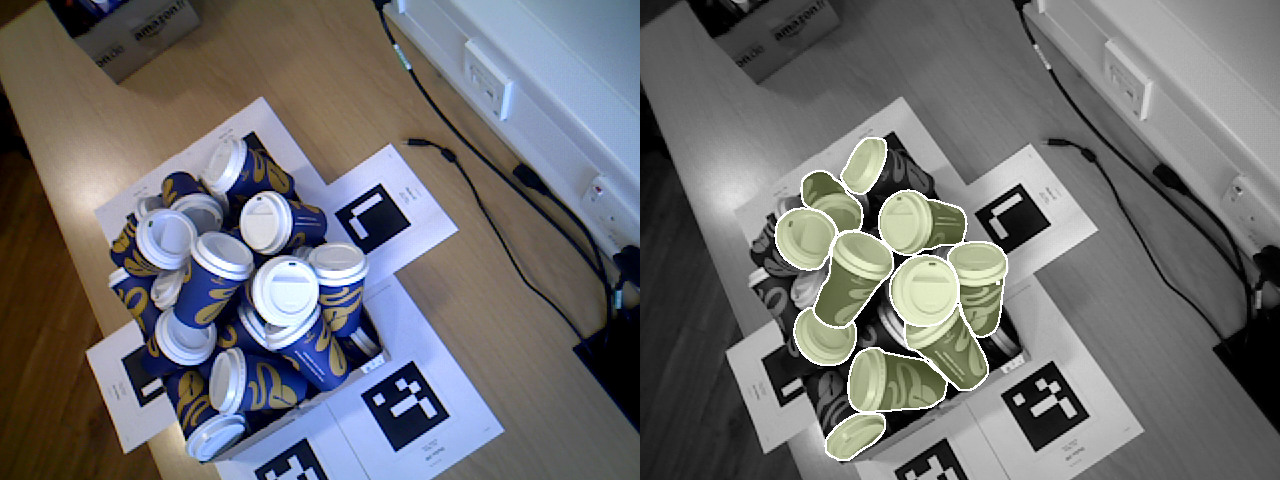

In [75]:
final_result = visualize(input_file, dataset_name, rgb_path)
final_result